In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
df = pd.read_csv(os.path.join(os.path.abspath('../data'), 'houses_to_rent_v2_dtcl.csv'))

In [3]:
df.shape

(8995, 13)

In the feature engineering process, it's important to see how the feature variables are related to our target variable, so let's plot a heatmap with our correlation matrix.

<AxesSubplot:>

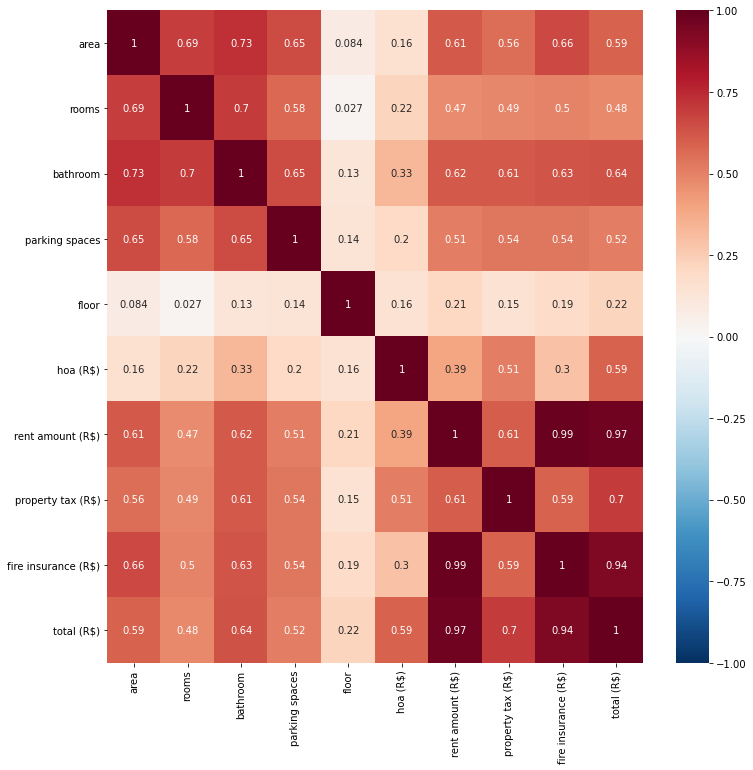

In [4]:
# Finally, let's see the correlation between features
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, cmap='RdBu_r', linecolor='black',vmin=-1, vmax=1)

We can see that almost every column are significant related to rent amount (R$).

- Floor doesn't appear to explain well our target variable, so we will not use in our feature engineering process.
- Total it's the sum of all the values of hoa, rent amount and property tax, so it's dependant on the rent price. We will not use it.

In [5]:
df = df.drop(columns=['floor', 'total (R$)'])

## Feature Creation

Now, let's create our features based on what we have. Feature creation is an art itself, so let's try and experiment.

For this case, since we are going to use Pipeline from sci-kit learn, we will create a class that will contain all of our creations that we will later create a step into the pipeline.

One key information it's that we can't create features based on our target variable because when we will predict that in the future, we won't have that information.

In [6]:
df.head()

,city,area,rooms,bathroom,parking spaces,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
0,Belo Horizonte,42,1,1,1,not acept,furnished,470,2690,172,36
1,Belo Horizonte,64,2,2,1,acept,not furnished,352,1500,80,20
2,Belo Horizonte,80,3,2,1,acept,not furnished,0,11000,425,181
3,Belo Horizonte,200,4,2,1,not acept,not furnished,850,2550,9,34
4,Belo Horizonte,45,1,1,1,acept,not furnished,500,1631,192,12


In [7]:
# First, let's import the BaseEstimator and TransformerMixin classes from sci-kit. Our model will inherit from these classes, since they give us pre-existing methods for free.
# Important: This variables will only exist in the Pipeline process. The original datasets will stay intact.
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureCreation(BaseEstimator, TransformerMixin):
    def __init__(self):
        print('FeatureCreation initialized')
    
    # For the fit method, we will pass the parameter x. This is our independent variables. 
    # This fit method will be called when we fit the pipeline.
    def fit(self, x, y=None):
        print('Fit FeatureCreation called')
        return self
    
    # Here, we will perform all of our transformations. For creating features automatic, we could create parameters in the class and pass the column names to them.
    # But in this case, since it's for this dataset specific, we will perform transformations in the column names directly into the fit method.
    # The transform method is called when we fit and when we predict using the Pipeline. And that's make sense, since we need to create our feature when we will train and when we will predict.
    def transform(self, x, y=None):
        print('Transform FeatureCreation called')
        # creating a copy to avoid changes to the original dataset
        x_ = x.copy()
        print(f'Before Transformation: {x_.shape}')
        # and now, we create everyone of our features.
        # Area power of two
        x_['area2'] = x_['area'] ** 2
        # The ratio between area and rooms
        x_['area/room'] = x_['area'] / x_['rooms']
        # The ratio between area and bathroom
        x_['area/bathroom'] = x_['area'] / x_['bathroom']
        # the sum of rooms and bathrooms
        x_['rooms+bathroom'] = x_['rooms'] + x_['bathroom']
        # the product between rooms and bathrooms
        x_['rooms*bathroom'] = x_['rooms'] * x_['bathroom']
        # the ratio between rooms and bathrooms
        x_['rooms/bathroom'] = x_['rooms'] / x_['bathroom']
        # the product between hoa and property tax
        x_['hoa*property tax'] = x_['hoa (R$)'] * x_['property tax (R$)']
        print(f'After Transformation: {x_.shape}')
        return x_

## Feature Transformation

Now that we have created our custom feature creation, let's define a target transformer.

On the data exploration, we see that our target variable it is right skewed. A common transformation used when this happens it's the logarithm of the variable.

This transformation will be performed by the TransformedTargetRegressor class by sci-kit learn.

This transformation can be made by custom functions, but since our it's the logarithm and the exponencial functions, it is not necessary to create a new one.

Below it is a test code to see how we wrap everything together. The pipeline it is our model and is passed to the TransformedTargetRegressor object. Then, we define the funcion that will be applied before the fit, and another that will be applied after we predict.

In [8]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import numpy as np

# In this step, we will pass our pipeline to the transformed target regressor.
# Now, our model it's a transformed target regressor object.

df_train = df.sample(frac=0.9,random_state=200)
df_test = df.drop(df_train.index)

cols = ['area', 'rooms', 'bathroom', 'parking spaces', 'property tax (R$)', 'fire insurance (R$)', 'hoa (R$)']
x = df_train[cols]
y = df_train['rent amount (R$)']
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

model_pipeline = Pipeline(steps=[
                    ('featurecreation', FeatureCreation()),
                    ('model', Ridge())
                ])

model = TransformedTargetRegressor(
    regressor=model_pipeline,
    func=np.log,
    inverse_func=np.exp
)

FeatureCreation initialized


In [9]:
# Now we fit and predict.
model.fit(x_train, y_train)

FeatureCreation initialized
Fit FeatureCreation called
Transform FeatureCreation called
Before Transformation: (6476, 7)
After Transformation: (6476, 14)


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('featurecreation',
                                                      FeatureCreation()),
                                                     ('model', Ridge())]))

In [10]:
model.predict(x_test)

Transform FeatureCreation called
Before Transformation: (1620, 7)
After Transformation: (1620, 14)


array([2101.23903621, 1113.01844552, 2779.28468075, ..., 2114.43104329,
       2795.60026153, 1842.8847265 ])

In [11]:
df.to_csv(os.path.join(os.path.abspath('../data'), 'houses_to_rent_v2_fteng.csv'), index=False)